In [1]:
# import cosima_cookbook as cc

import intake
from access_nri_intake.source.builders import AccessOm2Builder

import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
# import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
# from xhistogram.xarray import histogram


# logging.captureWarnings(True)
# logging.getLogger('py.warnings').setLevel(logging.ERROR)

import warnings

warnings.filterwarnings("ignore") # Suppress warnings for these docs

from dask.distributed import Client

# figdir = '/g/data/x77/wf4500/ASC_project/analysis_figs/'
figdir = '/g/data/e14/fbd581/ASC_project/Figures/'

In [2]:
# client = Client(memory_limit='1200gb',n_workers=48)

client = Client(threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39723,Workers: 14
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33585,Total threads: 1
Dashboard: /proxy/36753/status,Memory: 0 B
Nanny: tcp://127.0.0.1:40065,


In [3]:
# load Volume to calculate weighted depth-averages:
vol_bins = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Volume_rho_10deg_bins.nc')


In [4]:
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_10deg_bin.nc')

# resample monthly:
u_along_da_months = u_along.resample(time='1M').mean()#.U_along_contour_binned
# u_along_da_months = u_along_da_months.sel(potrho0=slice(13.8,28.42))#.rename({'lon_bin_midpoints': 'lon'})
u_along_da_months.load();

In [5]:
# monthly water mass mask 
age_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/**_age_mask.nc')


In [6]:
## snipcode to plot the regimes : test w/ w/o

# assigining numbers by regime clustering mask
import matplotlib
# colorsList_no3 = [('mediumseagreen'),('tomato'),('blueviolet')]
colorsList_no3 = [('mediumseagreen'),('blueviolet'),('tomato')]
CustomCmap_no3 = matplotlib.colors.ListedColormap(colorsList_no3)

clustering_mask = xr.open_mfdataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc')
clustering_mask_sum = xr.concat([clustering_mask.regimes_mask.isel(regime = reg_no) * (reg_no+1) for reg_no in range(3)], dim = 'regime').sum(dim = 'regime')


### treat U_along:

In [7]:
U_along_binned_CDW =  (age_mask.CDW_mask *u_along_da_months) #.weighted(vol_bins['volume'].fillna(0))


In [8]:
# CDW-layer
U_along_tmean_binned_CDW = U_along_binned_CDW

volume_tmean=vol_bins['volume'].mean('time')

U_along_tmean_binned_CDW = U_along_tmean_binned_CDW.weighted(vol_bins['volume'].fillna(0)).mean('potrho0').mean('time') ## vertical MEAN


In [9]:
# Obtain Ualong climatology:
U_along_annual = u_along.mean('time')

# this sectio calculate weighted-volume vertical sum for CSHT and vertical mean for U_along
U_along_annual_vavg = U_along_annual.weighted(vol_bins['volume'].fillna(0)).mean('potrho0').mean('time') ## weighted-vertical and time avg



In [10]:
# get lat/lon on contour to interp onto:
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')
CSHT_lon_along_contour = CSHT_along.lon_along_contour.isel(time = 0)
CSHT_lat_along_contour = CSHT_along.lat_along_contour.isel(time = 0)

In [11]:
###hu = cc.querying.getvar(expt, 'hu', session, n=1)

hu_file = '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle3/output490/ocean/ocean-2d-hu.nc'
ds = xr.open_dataset(hu_file)
hu = ds['hu']
ds.close()

In [12]:
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# Make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90


In [13]:

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [14]:
# now interpolate onto lon_along_contour 

U_along_annual_binned_CDW_interp = U_along_tmean_binned_CDW.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

U_along_annual_interp = U_along_annual_vavg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})


In [15]:
tmp=U_along_annual_binned_CDW_interp.to_array()
U_along_annual_binned_CDW_plot=tmp.isel(variable=0)

tmp=U_along_annual_interp.to_array()
U_along_annual_plot=tmp.isel(variable=0)



In [16]:
#Cross slope heat transport + ZC 
# Load CSHT field
CSHT_along_fine = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_rho/*').resample(time='1M').mean()

#importing u_along in thin bins
u_along_unbinned_fine = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_rho/OM2_IAF_XYgrid/*').resample(time='1M').mean()
u_along_unbinned_fine.u_along_contour.resample(time='1M').mean()

# #10 degrees binned ASC data monthly
#-already load as u_along

<xarray.DataArray 'u_along_contour' (time: 732, potrho0: 108,
                                     contour_index: 6002)> Size: 4GB
dask.array<transpose, shape=(732, 108, 6002), dtype=float64, chunksize=(1, 108, 6002), chunktype=numpy.ndarray>
Coordinates:
  * contour_index  (contour_index) int64 48kB 1 2 3 4 5 ... 5999 6000 6001 6002
  * potrho0        (potrho0) float64 864B 21.5 23.07 23.22 ... 28.13 28.14 29.08
  * time           (time) datetime64[ns] 6kB 1958-01-31 ... 2018-12-31

In [17]:
# 2) bin edges b/w -278.5:81.5
# csht.binned_cross_slope_heat_trans
#    - appending first 12 ponts in the last bin, so weight is uniform for all bins:
lon_bin=10
bin_edges = np.arange(CSHT_along_fine.lon_bin_midpoints[0], CSHT_along_fine.lon_bin_midpoints[-1]+(lon_bin/2), lon_bin)
lon_bin_mid = np.arange((bin_edges[0]+(lon_bin/2)),(bin_edges[-1]+(lon_bin/2)),lon_bin) # for 10-deg bins

newlon = np.concatenate((CSHT_along_fine.lon_bin_midpoints.values,np.arange(78.5,81.5,.25)), axis=0)
longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])

In [18]:
%%time
#binning CHST into 10 degrees bins
#creating a halo
CSHT_halo = xr.concat([CSHT_along_fine.binned_cross_slope_heat_trans,CSHT_along_fine.binned_cross_slope_heat_trans.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')*0.08
CSHT_along_10deg = CSHT_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') 


#now for the CSHT + zonal convergence
CSHTZC_halo = xr.concat([(CSHT_along_fine.binned_cross_slope_heat_trans +CSHT_along_fine.zonal_convergence),\
                         (CSHT_along_fine.binned_cross_slope_heat_trans +CSHT_along_fine.zonal_convergence)\
                         .isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')*0.08

CSHTZC_along_10deg = CSHTZC_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') 

del CSHT_halo, CSHTZC_halo


CSHT_along_10deg.load()
CSHTZC_along_10deg.load()

CPU times: user 29 s, sys: 2.49 s, total: 31.5 s
Wall time: 45.5 s


<xarray.DataArray (time: 732, potrho0: 108, lon_bin_midpoints_bins: 36)> Size: 23MB
array([[[ 0.00000000e+00, -3.72529030e-09,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -8.38190317e-09,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  2.79396772e-09,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  1.11758709e-08,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00, -5.58793545e-09,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00, -7.63684511e-08,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
        [ 0.00000000e+00, -7.15234604e+08,  7.13092054e+08, ...,
         -7.84385365e+06,  7.84385365e+06, -1.19762112e+09],
        [ 0.00000000e+00, -3.56612864e+08,  3.56612864e+08, ...,
          0.00000000e+00, -7.30156898e-07, -3.66010173e+08],
        [ 0.00000000e+00, -4.42837381e+08,  4.42837381e+08, ...,
          0.00000000e+00,  3.51667404e-06, -2.25750958e+09]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  1.49011612e-07,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00, -2.38418579e-07,  0.00000000e+00]]])
Coordinates:
  * potrho0                 (potrho0) float64 864B 21.5 23.07 ... 28.14 29.08
  * time                    (time) datetime64[ns] 6kB 1958-01-31 ... 2018-12-31
  * lon_bin_midpoints_bins  (lon_bin_midpoints_bins) object 288B (-278.5, -26...

In [19]:
CSHTZC_along_tmean_zsum_10deg = CSHTZC_along_10deg.mean('time').sum('potrho0')


In [20]:
CSHTZC_along_tmean_zsum_10deg

# rename coordinate 
CSHTZC_along_tmean_zsum_10deg_rename = CSHTZC_along_tmean_zsum_10deg.rename({'lon_bin_midpoints_bins': 'lon_bins'})

In [21]:
# replace by lon_bins (instead of Pandas Interval)
CSHTZC_along_tmean_zsum_10deg_rename['lon_bins'] = U_along_tmean_binned_CDW.lon_bins

In [22]:
# Convert DataArray to Dataset
CSHTZC_along_tmean_zsum_10deg_ds = CSHTZC_along_tmean_zsum_10deg_rename.to_dataset(name='variable_name')

CSHTZC_annual_binned_interp = CSHTZC_along_tmean_zsum_10deg_ds.interp(lon_bins=CSHT_lon_along_contour, method='nearest', kwargs={"fill_value": "extrapolate"}) 

tmp=CSHTZC_annual_binned_interp.to_array()
CSHTZC_annual_binned_plot=tmp.isel(variable=0)


In [23]:
#getting correction factor for the CSHT
factor = 1/((CSHT_along_fine.zonal_convergence + CSHT_along_fine.binned_cross_slope_heat_trans)\
.mean('time').sum()/ (CSHT_along_fine.unbinned_heat_transp_across_contour.mean('time').sum()))

In [24]:
#Importing masks 
CDW_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/CDW_age_mask.nc').CDW_mask.load()
DSW_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/DSW_age_mask.nc').DSW_mask.load()
AASW_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/AASW_age_mask.nc').AASW_mask.load()


In [25]:
# Import Wilma's mask with ASC regimes:
file_path = '/g/data/x77/wgh581/Post_Process/access-om2/ASC_regimes_01deg_jra55v13_ryf9091_plt_approach_smoothed_btm200m_50.npz'
ASC_regimes_all = np.load(file_path)
ASC_regimes = ASC_regimes_all['ASC_regimes_annual']
#ASC_regimes_monthly = ASC_regimes_all['ASC_regimes_monthly']
ASC_regimes_2d = np.vstack((ASC_regimes, ASC_regimes))

data_path = '/g/data/x77/wgh581/Post_Process/access-om2/'
file_name = 'Antarctic_slope_contour_1km_velocities_plt_approach.npz'

data = np.load(data_path + file_name)
# data.files
distance_along_contour_ASC = data['distance_along_contour']
lat_along_contour_ASC = data['lat_along_contour']
lon_along_contour_ASC = data['lon_along_contour']

# data.files

In [26]:
catalog = intake.cat.access_nri
esm_datastore = catalog["01deg_jra55v140_iaf_cycle3"]
esm_datastore_filtered = esm_datastore.search(variable="pot_rho_0",frequency="1mon")



In [27]:
dataset_dict = esm_datastore_filtered.to_dataset_dict(progressbar=False)


[gadi-hmem-bdw-0001:2983447:0:2983447] Caught signal 11 (Segmentation fault: invalid permissions for mapped object at address 0x14aa768ec150)
malloc(): unsorted double linked list corrupted
[gadi-hmem-bdw-0001:2983468:0:2983468] Caught signal 11 (Segmentation fault: address not mapped to object at address 0x18c)
2025-08-04 18:13:19,407 - tornado.application - ERROR - Exception in callback <bound method Worker.trigger_profile of <Worker 'tcp://127.0.0.1:34495', name: 13, status: running, stored: 0, running: 1/1, ready: 1, comm: 0, waiting: 0>>
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/profile.py", line 66, in identifier
    co.co_name,
    ^^^^^^^^^^
AttributeError: 'str' object has no attribute 'co_name'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site

In [28]:
%%time
# #this cell below might take a good time to run
CSHTZC_z = xr.open_dataset('/g/data/v45/wf4500/ASC_project_files/'+\
                           'Cross_slope_heat_transport/OM2_IAF/daily_z/'+\
                           'Ant_cross_slope_heat_terms_offline_1000m_1958-01.nc').isel(time=0)

#unbinned mask
unbinned_depth_mask=CSHTZC_z.unbinned_heat_transp_across_contour
unbinned_depth_mask = (unbinned_depth_mask.where(unbinned_depth_mask!=np.nan)*0+1)

#density
ylength=580

potrho = dataset_dict['ocean_3d_pot_rho_0_1_monthly_mean_ym_XXXX_XX.1mon']['pot_rho_0']
potrho_transect = potrho.isel(yt_ocean=slice(0,ylength)).sel(xt_ocean = CSHT_along_fine.lon_along_contour.isel(time=0).drop('time'),\
    yt_ocean=CSHT_along_fine.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask

potrho_transect.load()
print('loaded densities along contour')

loaded densities along contour
CPU times: user 4min 58s, sys: 11.7 s, total: 5min 10s
Wall time: 5min 18s


In [29]:
esm_datastore_filtered = esm_datastore.search(variable="dzt",frequency="1mon")
dataset_dict = esm_datastore_filtered.to_dataset_dict(progressbar=False)
# dataset_dict

In [30]:

dzt = dataset_dict['ocean_3d_dzt_1_monthly_mean_ym_XXXX_XX.1mon']['dzt']
dzt_transect = dzt.isel(yt_ocean=slice(0,ylength)).sel(xt_ocean = CSHT_along_fine.lon_along_contour.isel(time=0).drop('time'),\
    yt_ocean=CSHT_along_fine.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask


In [31]:
area_file = '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle3/output490/ocean/ocean-2d-area_t.nc'
ds = xr.open_dataset(area_file)
area = ds['area_t']
ds.close()

area_transect = area.isel(yt_ocean=slice(0,ylength)).sel(xt_ocean = CSHT_along_fine.lon_along_contour.isel(time=0).drop('time'),\
    yt_ocean=CSHT_along_fine.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask
area_transect = area_transect.drop('time')

#volume will be
vol_transect = area_transect * dzt_transect


# #loading data
dzt_transect.load()
area_transect.load()
vol_transect.load()


<xarray.DataArray (contour_index: 6002, st_ocean: 75, time: 732)> Size: 1GB
array([[[22924824., 22924714., 22924856., ..., 22924650., 22924044.,
         22924544.],
        [25334384., 25334260., 25334418., ..., 25334192., 25333522.,
         25334076.],
        [27997186., 27997046., 27997220., ..., 27996972., 27996232.,
         27996842.],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[22925020., 22924948., 22925120., ..., 22924888., 22924258.,
         22924746.],
        [25334600., 25334522., 25334710., ..., 25334456., 25333758.,
         25334298.],
        [27997420., 27997338., 27997544., ..., 27997264., 27996492.,
         27997090.],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[22934110., 22933954., 22934006., ..., 22933882., 22933454.,
         22933872.],
        [25344644., 25344472., 25344532., ..., 25344396., 25343922.,
         25344384.],
        [28008522., 28008332., 28008398., ..., 28008246., 28007726.,
         28008236.],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
    xt_ocean       (contour_index) float64 48kB -279.8 -279.7 ... 79.95 79.95
    yt_ocean       (contour_index) float64 48kB -66.03 -66.03 ... -66.03 -66.03
  * contour_index  (contour_index) int64 48kB 1 2 3 4 5 ... 5999 6000 6001 6002
  * st_ocean       (st_ocean) float64 600B 0.5413 1.681 ... 5.511e+03 5.709e+03
    TLON           (contour_index) float32 24kB 80.05 80.15 ... 79.95 79.95
    TLAT           (contour_index) float32 24kB -66.03 -66.03 ... -66.07 -66.03
    ULON           (contour_index) float32 24kB -279.9 -279.8 ... 80.0 80.0
    ULAT           (contour_index) float32 24kB -66.01 -66.01 ... -66.05 -66.01
  * time           (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2018-12-...

Lets now bin the density in 3 degrees, in a similar manner as it is done for the CSHT first step



In [32]:
#binning into 3deg
bin_width = 3
bin_spacing = 0.25
lon_west = -280
lon_east = 80

# new coordinate and midpoints of longitude bins:
full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)

n_bin_edges = len(full_lon_coord)
lon_along_contour = np.array(CSHTZC_z.lon_along_contour)
lat_along_contour = np.array(CSHTZC_z.lat_along_contour)
# sum into longitude bins:
# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
# on the isobath contour and sum continously along contour between defined indices.
# (i.e. lon_along_contour is not monotonic)
# find points on contour to define edges of longitude bins:
bin_edge_indices = np.zeros(n_bin_edges)
for lon_bin in range(n_bin_edges-1):
    # find first isobath point that has the right longitude:
    first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
    # then find all other isobath points with the same longitude as that first point:
    same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
    # we want the most southerly of these points on the same longitude line:
    bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
    
# define east/west edges:
bin_edge_indices = bin_edge_indices.astype(int)
bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
n_bins = len(bin_edge_indices_west)


lat_bin_midpoints = np.zeros(n_bins)
for lon_bin in range(n_bins):
    # find nearest isobath point:
    lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
    lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]

# average the densities along the contour, in the z space
vol_transect = vol_transect.transpose('time','st_ocean','contour_index') #making sure the dimensions are correctly aligned for indexing
potrho_transect = potrho_transect.transpose('time','st_ocean','contour_index') #making sure the dimensions are correctly aligned for indexing
σ_contour_3deg = np.zeros([732,75,n_bins])*np.nan
for lon_bin in range(n_bins):
    σ_contour_3deg0 = potrho_transect[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    distance_along0 = vol_transect[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    #making sure we only have distances where there are values
    distance_along0 = ((σ_contour_3deg0 *0)+1) *distance_along0
    σ_contour_3deg[:,:,lon_bin] = (np.nansum(σ_contour_3deg0*distance_along0,axis=2)/np.nansum(distance_along0,axis=2))

#removing zeros
σ_contour_3degnp = np.where(σ_contour_3deg!=0,σ_contour_3deg,np.nan) - 1000

In [33]:
# #transforming it into xarray
CSHTZC_zm = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')


CSHT_z_monthly =( (CSHTZC_zm.binned_cross_slope_heat_trans)*factor ).resample(time='1M').mean().load()

σ_contour_3deg = CSHT_z_monthly.copy()
σ_contour_3deg.name = 'sigma0'
σ_contour_3deg.values = σ_contour_3degnp

Binning the volume in 3 degree bins too for future averaging

In [34]:
#getting the sum of the volume in 3 deg bins, z coods

vol_transect = vol_transect.transpose('time','st_ocean','contour_index') #making sure the dimensions are correctly aligned for indexing
vol_contour_3deg_z = np.zeros([732,75,n_bins])*np.nan
for lon_bin in range(n_bins):
    vol_contour_3deg0_z = vol_transect[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    vol_contour_3deg_z[:,:,lon_bin] = (np.nansum(vol_contour_3deg0_z,axis=2))

#removing zeros
vol_contour_3degnp_z = np.where(vol_contour_3deg_z!=0,vol_contour_3deg_z,np.nan)

In [35]:
#volume_z
vol_contour_3deg_z = CSHT_z_monthly.copy()
vol_contour_3deg_z.name = 'Volume'
vol_contour_3deg_z.values = vol_contour_3degnp_z

Binning the new density into 10 degree bins



In [36]:
# 2) bin edges b/w -278.5:81.5
# csht.binned_cross_slope_heat_trans
#    - appending first 12 ponts in the last bin, so weight is uniform for all bins:
lon_bin=10
bin_edges = np.arange(CSHTZC_z.lon_bin_midpoints[0], CSHTZC_z.lon_bin_midpoints[-1]+(lon_bin/2), lon_bin)
lon_bin_mid = np.arange((bin_edges[0]+(lon_bin/2)),(bin_edges[-1]+(lon_bin/2)),lon_bin) # for 10-deg bins

newlon = np.concatenate((CSHTZC_z.lon_bin_midpoints.values,np.arange(78.5,81.5,.25)), axis=0)

In [37]:
# creating the volume array for a proper weighted mean, z
#- 1st) append the first 12 points along the contour in the end, so all bins have the same n of points 
vol_contour_3deg_z_halo = xr.concat([vol_contour_3deg_z,vol_contour_3deg_z.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')

longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
vol_contour_3deg_z_halo['lon_bin_midpoints'] = longfix

vol_10deg_binned_z = vol_contour_3deg_z_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')

In [38]:
# Binning sigma into 10 degrees bins, z
#- 1st) append the first 12 points along the contour in the end, so all bins have the same n of points 
σ_contour_3deg_halo = xr.concat([σ_contour_3deg,σ_contour_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')

longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
σ_contour_3deg_halo['lon_bin_midpoints'] = longfix

σ_contour_3deg_halo = σ_contour_3deg_halo* vol_contour_3deg_z_halo #contour density multiplied by the volume in z coordinates

σ_10deg_binned = σ_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') /\
vol_contour_3deg_z_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')

In [39]:
CDW_mean_mask = CDW_mask.where(CDW_mask!=0).mean('time')
CDW_mean_mask_roundup = (CDW_mean_mask.where(CDW_mean_mask !=0)*0)+1

#Below is the minimum CDW density in each lon bin, found for the entire timeseries. it would be the surface bound of the light limit
CDW_minlight_sigma = CDW_mean_mask_roundup[::-1,:].potrho0[CDW_mean_mask_roundup[::-1,:].cumsum('potrho0').argmax(dim='potrho0')]

#Below is the maximum CDW density in each lon bin, found for the entire timeseries. it would be the deepest bound of the dense limit
CDW_maxdense_sigma = CDW_mean_mask_roundup.potrho0[CDW_mean_mask_roundup.cumsum('potrho0').argmax(dim='potrho0')]

Lets create an array locating the light density treshold of CDW every timestep, for each bin



In [40]:
#Below we have the range of densities that are selected by the lightest layer
CDW_mask_cumsumDown = CDW_mask.where(CDW_mask!=0).cumsum('potrho0').where(CDW_mask!=0)
CDW_lightlimit_range = CDW_mask_cumsumDown.where(CDW_mask_cumsumDown<=1) #extracted here the lightest density treshhold at all times

mask = (CDW_lightlimit_range == 1)
time_indices, potrho0_indices, lon_bins_indices = np.where(mask)

potrho0_values = CDW_mask.coords['potrho0'].values[potrho0_indices]
time_values = CDW_mask.coords['time'].values[time_indices]
lon_bins_values = CDW_mask.coords['lon_bins'].values[lon_bins_indices]



CDW_light_potrho0 = xr.DataArray(
    data=potrho0_values,
    dims=['time'],
    coords={'time':time_values})
CDW_light_potrho0.name = 'potrho0'

CDW_light_lons = xr.DataArray(
    data=lon_bins_values,
    dims=['time'],
    coords={'time':time_values})
CDW_light_lons.name = 'lon_bins'
#The linear array below has the locations of the lightest limit
CDW_light_linear = xr.merge((CDW_light_potrho0,CDW_light_lons)).sortby('lon_bins').sortby('time')


#below is an 2d xarray mapping the lighter limit of CDW in each timestep
CDW_light = xr.DataArray(
    data=CDW_light_linear.potrho0.values.reshape(732,36),  # Reshape according to lon_bins and time
    dims=['time','lon_bins'],
    coords={'time': CDW_light_linear.time[:732].values,'lon_bins': CDW_light_linear.lon_bins[:36].values})  # Use unique values

del potrho0_values, time_values, lon_bins_values, mask, CDW_light_potrho0, CDW_light_lons

Lets create the analogue now for the dense limit

In [41]:
#Below we have the range of densities that are selected by the lightest layer
CDW_mask_cumsumUp= CDW_mask.where(CDW_mask!=0)[:,::-1,:].cumsum('potrho0').where(CDW_mask!=0)[:,::-1,:]
CDW_denselimit_range = CDW_mask_cumsumUp.where(CDW_mask_cumsumUp<=1) #extracted here the densest density treshhold at all times

mask = (CDW_denselimit_range == 1)
time_indices, potrho0_indices, lon_bins_indices = np.where(mask)


potrho0_values = CDW_mask.coords['potrho0'].values[potrho0_indices]
time_values = CDW_mask.coords['time'].values[time_indices]
lon_bins_values = CDW_mask.coords['lon_bins'].values[lon_bins_indices]

CDW_dense_potrho0 = xr.DataArray(
    data=potrho0_values,
    dims=['time'],
    coords={'time':time_values})
CDW_dense_potrho0.name = 'potrho0'

CDW_dense_lons = xr.DataArray(
    data=lon_bins_values,
    dims=['time'],
    coords={'time':time_values})
CDW_dense_lons.name = 'lon_bins'
#The linear array below has the locations of the densest limit
CDW_dense_linear = xr.merge((CDW_dense_potrho0,CDW_dense_lons)).sortby('lon_bins').sortby('time')



#below is an 2d xarray mapping the denser limit of CDW in each timestep
CDW_dense = xr.DataArray(
    data=CDW_dense_linear.potrho0.values.reshape(732,36),  # Reshape according to lon_bins and time
    dims=['time','lon_bins'],
    coords={'time': CDW_dense_linear.time[:732].values,'lon_bins': CDW_dense_linear.lon_bins[:36].values})  # Use unique values

del potrho0_values, time_values, lon_bins_values, mask

Lets calcualte the mean, minimum and maximum density valu of each on of the vertical limts

In [42]:
#mean limits
CDW_light_mean = CDW_light.mean('time')
CDW_dense_mean = CDW_dense.mean('time')

#min limits
CDW_light_min = CDW_light.min('time')
CDW_dense_min = CDW_dense.min('time')

#min limits
CDW_light_max = CDW_light.max('time')
CDW_dense_max = CDW_dense.max('time')

In [43]:
#standardizing he format of time and lon_bins in each xarray
CDW_light['time'] = σ_10deg_binned.time
CDW_light['lon_bins'] = σ_10deg_binned.lon_bin_midpoints_bins.values
CDW_dense['time'] = σ_10deg_binned.time
CDW_dense['lon_bins'] = σ_10deg_binned.lon_bin_midpoints_bins.values

We now need to locate the depth of each density value in our density curtain. We need to lcoate them in the st_edges_ocean variable to make sure we are locating the top and the bottom of the specific cells

In [44]:
st_edges_file = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v140_iaf_cycle3/output488/ocean/ocean-3d-passive_adelie-1-daily-mean-ym_1958_01.nc'
ds = xr.open_dataset(st_edges_file)
st_edges = ds['st_edges_ocean']
ds.close()
st_edges_top=st_edges[:-1]
st_edges_bottom=st_edges[1:]

In [45]:
#depth of light layer along time
CDW_light_z = st_edges_top.isel(st_edges_ocean=\
                                           (((σ_10deg_binned.rename({'lon_bin_midpoints_bins':'lon_bins'}) - \
                                              CDW_light)**2)**0.5).argmin('st_ocean'))
#depth of denst layer along time
CDW_dense_z = st_edges_bottom.isel(st_edges_ocean=\
                                           (((σ_10deg_binned.rename({'lon_bin_midpoints_bins':'lon_bins'}) - \
                                              CDW_dense)**2)**0.5).argmin('st_ocean'))

#average minimum and maximum depths
CDW_light_zmean=CDW_light_z.mean('time')
CDW_dense_zmean=CDW_dense_z.mean('time')


#shallowest minimum and maximum depths
CDW_light_zmin=CDW_light_z.min('time')
CDW_dense_zmin=CDW_dense_z.min('time')


#deepest minimum and maximum depths
CDW_light_zmax=CDW_light_z.max('time')
CDW_dense_zmax=CDW_dense_z.max('time')

In [46]:
#creating a halo for plot
lon_bin_halo = np.append(np.append(-280,lon_bin_mid),85)

#halo-ing light_mean
CDW_light_zmean_halo = xr.concat([CDW_light_zmean[0],CDW_light_zmean,CDW_light_zmean[-1]],dim='lon_bins')
CDW_light_zmean_halo['lon_bins'] = lon_bin_halo

#halo-ing dense_mean
CDW_dense_zmean_halo = xr.concat([CDW_dense_zmean[0],CDW_dense_zmean,CDW_dense_zmean[-1]],dim='lon_bins')
CDW_dense_zmean_halo['lon_bins'] = lon_bin_halo

#halo-ing light_min
CDW_light_zmin_halo = xr.concat([CDW_light_zmin[0],CDW_light_zmin,CDW_light_zmin[-1]],dim='lon_bins')
CDW_light_zmin_halo['lon_bins'] = lon_bin_halo

#halo-ing dense_max
CDW_dense_zmax_halo = xr.concat([CDW_dense_zmax[0],CDW_dense_zmax,CDW_dense_zmax[-1]],dim='lon_bins')
CDW_dense_zmax_halo['lon_bins'] = lon_bin_halo

In [47]:
#lets mask teh CSHT by Water mass

#CDW heat transport
CDW_mask['lon_bins'] = CSHTZC_along_10deg.lon_bin_midpoints_bins.values
CDW_HT_10deg = CSHTZC_along_10deg.rename({'lon_bin_midpoints_bins':'lon_bins'}) * CDW_mask


#AASW heat transport
AASW_mask['lon_bins'] = CSHTZC_along_10deg.lon_bin_midpoints_bins.values
AASW_HT_10deg = CSHTZC_along_10deg.rename({'lon_bin_midpoints_bins':'lon_bins'}) * AASW_mask


#DSW heat transport
DSW_mask['lon_bins'] = CSHTZC_along_10deg.lon_bin_midpoints_bins.values
DSW_HT_10deg = CSHTZC_along_10deg.rename({'lon_bin_midpoints_bins':'lon_bins'}) * DSW_mask

Calculating the mean ASC speed in each water mass layer too

In [48]:
U_10deg = u_along.U.load()

In [49]:
#CDW heat transport
U_10deg['lon_bins'] = CDW_mask.lon_bins


#AASW
AASW_U_10deg = (U_10deg * AASW_mask).mean('time')
AASW_U_10deg = AASW_U_10deg.where(AASW_U_10deg!=0).mean('potrho0')

#CDW
CDW_U_10deg = (U_10deg * CDW_mask).mean('time')
CDW_U_10deg = CDW_U_10deg.where(CDW_U_10deg!=0).mean('potrho0')

#DSW
DSW_U_10deg = (U_10deg * DSW_mask).mean('time')
DSW_U_10deg = DSW_U_10deg.where(DSW_U_10deg!=0).mean('potrho0')

### Figure 2

In [50]:
from matplotlib import gridspec
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


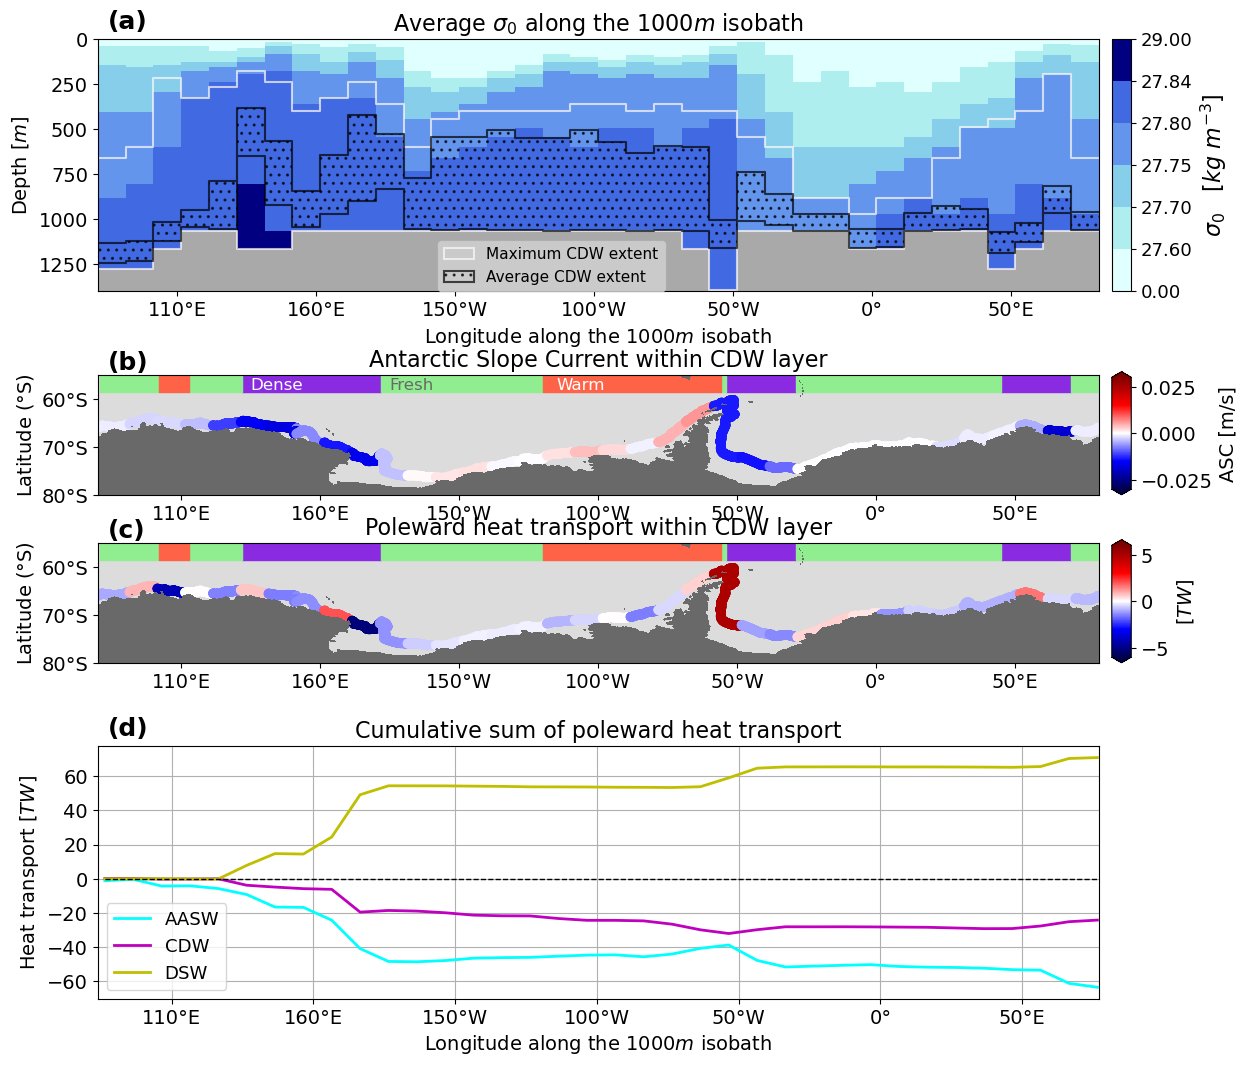

In [52]:
figure = plt.figure(num = 1, figsize = (13, 12))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.87,
                    top=0.9,
                    wspace=0,
                    hspace=0.4)

ax=plt.subplot(3,1,1)
norm = col.Normalize(vmin=27.6,vmax=29)
levels = [0,27.6,27.7,27.75,27.8,27.84,29]

pc = σ_10deg_binned.mean('time').plot.pcolormesh(y='st_ocean',levels=levels,\
                                       colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue',\
                                               'navy'],add_colorbar=False)

plt.fill_between(lon_bin_halo,CDW_light_zmin_halo,CDW_dense_zmax_halo,color='snow',\
                 step='mid',hatch='',facecolor='none', alpha=.7, label='Maximum CDW extent',linewidth=1.5)

plt.fill_between(lon_bin_halo,CDW_light_zmean_halo,CDW_dense_zmean_halo,\
                 step='mid',hatch='..',facecolor='none', alpha=0.7, label='Average CDW extent',linewidth=1.5)
ax.set_facecolor('darkgray')


plt.ylim(1400,0);
plt.tick_params(labelsize=14)
plt.ylabel(r'Depth [$m$]',fontsize=14)
plt.xlabel('Longitude along the 1000$m$ isobath',fontsize=14)
plt.legend(fontsize=11, bbox_to_anchor=(0.574,0.23), facecolor='lightgray')
ax.xaxis.set_major_formatter(LongitudeFormatter())

plt.title(r'Average $\sigma_0$ along the 1000$m$ isobath',fontsize=16)

cbax = figure.add_axes([0.88, 0.69, 0.015, 0.21])
cbr = plt.colorbar(pc, cax = cbax, orientation = 'vertical')
# cbr = plt.colorbar(pc)
cbr.ax.set_ylabel(ylabel=r"$\sigma_0$   [$kg\ m^{-3}$]",size=16)
cbr.ax.tick_params(labelsize=13)

ax.text(0.01,1.04,'(a)',transform=ax.transAxes, fontsize = 18, fontweight = 'bold')


# spec = gridspec.GridSpec(ncols=2, nrows=2,
#                          width_ratios=[15,0.1], wspace=0.5,
#                          hspace=0.1, height_ratios=[1, 0.4])

# ax2 = figure.add_subplot(spec[2])
ax2=plt.subplot(3,1,3)


(AASW_HT_10deg.mean('time').sum('potrho0')*1e-12).cumsum().plot(ax=ax2,color='cyan',\
                                                                linewidth=2,label='AASW')
(CDW_HT_10deg.mean('time').sum('potrho0')*1e-12).cumsum().plot(ax=ax2,color='m',\
                                                                linewidth=2,label='CDW')
(DSW_HT_10deg.mean('time').sum('potrho0')*1e-12).cumsum().plot(ax=ax2,color='y',\
                                                                linewidth=2,label='DSW')
(AASW_HT_10deg.mean('time').sum('potrho0')*0).plot(ax=ax2, linestyle='--', color='k',linewidth=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-276,77)
plt.title('Cumulative sum of poleward heat transport',fontsize=16)
plt.ylabel(r'Heat transport [$TW$]',fontsize=14)
plt.xlabel('Longitude along the 1000$m$ isobath',fontsize=14)
plt.grid()
legend1 = plt.legend(fontsize=13,loc='lower left')
ax2.text(0.01,1.04,'(d)',transform=ax2.transAxes, fontsize = 18, fontweight = 'bold')
ax2.xaxis.set_major_formatter(LongitudeFormatter())

fontsize=14

ax1 = figure.add_subplot(6,1,3)

scat = ax1.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,
                       c = U_along_annual_binned_CDW_plot,
                       cmap = 'seismic', vmin = -0.03, vmax = 0.03)
ax1.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='dimgrey', zorder=2)
ax1.set_facecolor('gainsboro') 
ax1.set_ylim([-80,-55])
ax1.set_ylabel('Latitude ($\degree$S)',fontsize=fontsize)
ax1.set_title('Antarctic Slope Current within CDW layer',fontsize=16)
ax1.tick_params(labelsize=fontsize)

ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax1.xaxis.set_major_formatter(LongitudeFormatter())
ax1.text(0.01,1.04,'(b)',transform=ax1.transAxes, fontsize = 18, fontweight = 'bold')
# ax1.pcolormesh(lon_along_contour_ASC[:-1],[-59,-57], ASC_regimes_2d[:,:-1], cmap=CustomCmap_no3, alpha = 1)
## replace by Moorman et al. 2020
## THOMPSON et al 2018 COMPARISON (estimated from Figure 4)
## D regions
ax1.fill_between([-29,-54],[-58.5,-58.5],[-55, -55], color = 'blueviolet')
ax1.fill_between([-178,-228],[-58.5,-58.5],[1,1], color = 'blueviolet')
ax1.fill_between([70,45],[-58.5,-58.5],[1,1], color = 'blueviolet')
# ## F regions
ax1.fill_between([-54,-56],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax1.fill_between([-120,-178],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax1.fill_between([-228,-247],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax1.fill_between([-279,-258],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax1.fill_between([70,80],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax1.fill_between([-29,45],[-58.5,-58.5],[1,1], color = 'lightgreen')
# ## W regions
ax1.fill_between([-120,-56],[-58.5,-58.5],[1,1], color = 'tomato')
ax1.fill_between([-247,-258],[-58.5,-58.5],[1,1], color = 'tomato')
ax1.text(-115,-58.,'Warm',color='white',fontsize=12)#,weight='bold')
ax1.text(-175,-58.,'Fresh',color='dimgray',fontsize=12)#,weight='bold')
ax1.text(-225,-58.,'Dense',color='white',fontsize=12)#,weight='bold')

cbax = figure.add_axes([0.88, 0.52, 0.015, 0.1025])
cbar = plt.colorbar(scat, cax = cbax, orientation = 'vertical',extend = 'both')
# cbar = plt.colorbar(scat)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('ASC [m/s]', fontsize=14)


ax2 = figure.add_subplot(6,1,4)

scat = ax2.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,
                       c = CSHTZC_annual_binned_plot*1e-12,
                       cmap = 'seismic', vmin = -6., vmax = 6.)
ax2.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='dimgrey', zorder=2)
ax2.set_facecolor('gainsboro') 
ax2.set_ylim([-80,-55])
ax2.set_ylabel('Latitude ($\degree$S)',fontsize=fontsize)
# ax2.set_xlabel('Longitude ($\degree$E)',fontsize=fontsize)
ax2.set_title('Poleward heat transport within CDW layer',fontsize=16)
ax2.tick_params(labelsize=fontsize)

ax2.yaxis.set_major_formatter(LatitudeFormatter())
ax2.xaxis.set_major_formatter(LongitudeFormatter())
ax2.text(0.01,1.04,'(c)',transform=ax2.transAxes, fontsize = 18, fontweight = 'bold')
ax2.fill_between([-29,-54],[-58.5,-58.5],[-55, -55], color = 'blueviolet')
ax2.fill_between([-178,-228],[-58.5,-58.5],[1,1], color = 'blueviolet')
ax2.fill_between([70,45],[-58.5,-58.5],[1,1], color = 'blueviolet')
# ## F regions
ax2.fill_between([-54,-56],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax2.fill_between([-120,-178],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax2.fill_between([-228,-247],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax2.fill_between([-279,-258],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax2.fill_between([70,80],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax2.fill_between([-29,45],[-58.5,-58.5],[1,1], color = 'lightgreen')
# ## W regions
ax2.fill_between([-120,-56],[-58.5,-58.5],[1,1], color = 'tomato')
ax2.fill_between([-247,-258],[-58.5,-58.5],[1,1], color = 'tomato')

cbax = figure.add_axes([0.88, 0.38, 0.015, 0.1025])
cbar = plt.colorbar(scat, cax = cbax, orientation = 'vertical',extend = 'both')
# cbar = plt.colorbar(scat)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('[$TW$]', fontsize=14)

plt.savefig(figdir +'Fig1_final_v2.png',dpi=400)

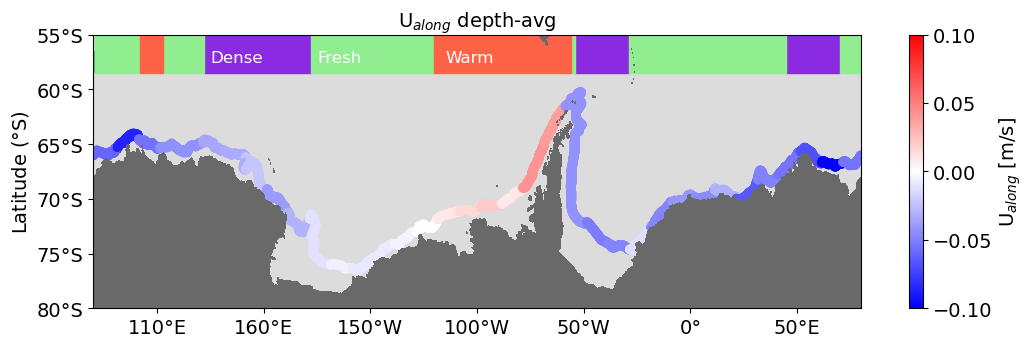

In [53]:
### U_along full-depth averaged for SM:

figure = plt.figure(num = 1, figsize = (12, 13))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0,
                    hspace=0.4)

fontsize=14
ax1 = figure.add_subplot(3,1,1)

scat = ax1.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,
                       c = U_along_annual_plot,
                       cmap = 'bwr', vmin = -0.1, vmax = 0.1)
ax1.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='dimgrey', zorder=2)
ax1.set_facecolor('gainsboro') 
ax1.set_ylim([-80,-55])
ax1.set_ylabel('Latitude ($\degree$S)',fontsize=fontsize)
# ax1.set_xlabel('Longitude ($\degree$E)',fontsize=fontsize)
ax1.set_title('Antarctic Slope Current  depth-averaged',fontsize=fontsize) ### U-Along
ax1.tick_params(labelsize=fontsize)
cbar = plt.colorbar(scat)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('U$_{along}$ [m/s]', fontsize=14)
ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax1.xaxis.set_major_formatter(LongitudeFormatter())
# ax1.text(0.01,0.84 ,'(a)',transform=ax1.transAxes, fontsize = 18, fontweight = 'bold')

# ax1.pcolormesh(clustering_mask.lon, [-58,-57],  np.vstack((clustering_mask_sum,clustering_mask_sum)), cmap=CustomCmap_no3, alpha = 0.5)
ax1.pcolormesh(lon_along_contour_ASC[:-1],[-58,-57], ASC_regimes_2d[:,:-1], cmap=CustomCmap_no3, alpha = 1)
## THOMPSON et al 2018 COMPARISON (estimated from Figure 4)
## D regions
ax1.fill_between([-29,-54],[-58.5,-58.5],[-55, -55], color = 'blueviolet')
ax1.fill_between([-178,-228],[-58.5,-58.5],[1,1], color = 'blueviolet')
ax1.fill_between([70,45],[-58.5,-58.5],[1,1], color = 'blueviolet')
# ## F regions
ax1.fill_between([-54,-56],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax1.fill_between([-120,-178],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax1.fill_between([-228,-247],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax1.fill_between([-279,-258],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax1.fill_between([70,80],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax1.fill_between([-29,45],[-58.5,-58.5],[1,1], color = 'lightgreen')
# ## W regions
ax1.fill_between([-120,-56],[-58.5,-58.5],[1,1], color = 'tomato')
ax1.fill_between([-247,-258],[-58.5,-58.5],[1,1], color = 'tomato')
ax1.text(-115,-57.5,'Warm',color='white',fontsize=12)#,weight='bold')
ax1.text(-175,-57.5,'Fresh',color='white',fontsize=12)#,weight='bold')
ax1.text(-225,-57.5,'Dense',color='white',fontsize=12)#,weight='bold')


plt.savefig(figdir +'Fig1_final_v2_SM.png',dpi=300)

#### test new fig 1 b/c panels:

In [ ]:
# ## now interpolate onto lon_along_contour 

# U_along_annual_binned_CDW_interp = U_along_tmean_binned_CDW.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# U_along_annual_interp = U_along_annual_vavg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# tmp=U_along_annual_binned_CDW_interp.to_array()
# U_along_annual_binned_CDW_plot=tmp.isel(variable=0)

# tmp=U_along_annual_interp.to_array()
# U_along_annual_plot=tmp.isel(variable=0)


In [74]:
CSHT_lat_along_contour_londim = CSHT_lat_along_contour.rename({'contour_index':'lon_along_contour'}).copy()
CSHT_lat_along_contour_londim['lon_along_contour'] = CSHT_lon_along_contour.values

lat_bins_10deg = 1+ CSHT_lat_along_contour_londim.groupby_bins('lon_along_contour', bins=bin_edges).mean('lon_along_contour').compute()


In [90]:
CSHTZC_along_tmean_zsum_10deg_ds.variable_name

<xarray.DataArray 'variable_name' (lon_bins: 36)>
array([-1.02089711e+12,  8.51751202e+11, -4.23438140e+12,  3.01852471e+10,
       -1.49566363e+12,  6.65842185e+11, -1.52114923e+12, -1.35276012e+12,
        2.05678594e+12, -5.22649650e+12, -1.30598711e+12, -5.63869775e+11,
       -3.05371936e+11, -1.59447319e+11, -1.88119839e+11, -1.86581946e+11,
       -8.84277994e+11, -4.78690275e+11,  1.88341032e+10, -1.50003084e+12,
       -4.56818876e+11,  5.17654166e+11,  4.96367515e+12, -1.11777484e+12,
       -1.38636916e+12,  5.01221326e+11,  5.22789234e+11,  3.23112861e+11,
       -1.23948120e+12, -5.22602357e+11, -6.18440848e+11, -9.00206874e+11,
       -9.12620339e+11,  1.62895020e+12, -4.52702266e+11, -8.10190915e+11])
Coordinates:
  * lon_bins  (lon_bins) float64 -273.5 -263.5 -253.5 -243.5 ... 56.5 66.5 76.5

In [114]:
import cmocean.cm as cmocean

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

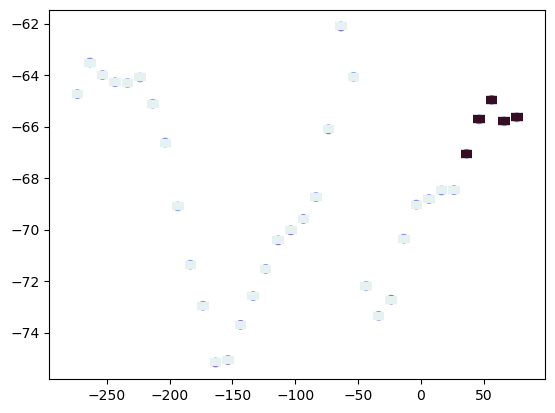

In [121]:
# plt.scatter(U_along_tmean_binned_CDW.lon_bins,lat_bins_10deg,c=U_along_tmean_binned_CDW.U)


vall = U_along_tmean_binned_CDW.lon_bins.values
barcolorvar = 'vall'
lon = U_along_tmean_binned_CDW.lon_bins

cmap = discrete_cmap(10, cmocean.dense)

plt.scatter(U_along_tmean_binned_CDW.lon_bins,lat_bins_10deg, c=U_along_tmean_binned_CDW.U, vmin=-0.05,vmax=0.05, cmap = cmap)
plt.hlines(lat_bins_10deg,lon - 4.6,  # Start of line
                lon + 4.6,  # End of line
                color=cmap(norm(eval(barcolorvar))),  # Map r_sq or slope value to a color
                linewidth=6  # Optional: Set line width
            )

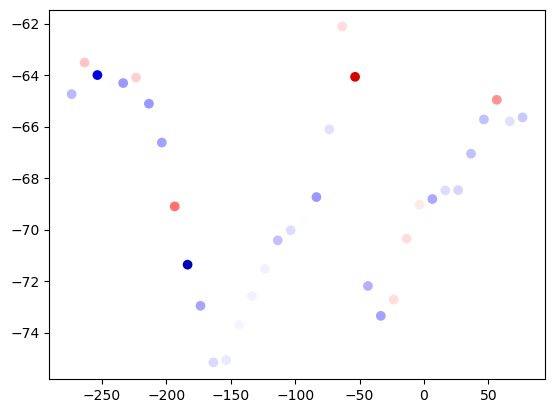

In [91]:
# CSHTZC_along_tmean_zsum_10deg_ds

plt.scatter(U_along_tmean_binned_CDW.lon_bins,lat_bins_10deg, c=CSHTZC_along_tmean_zsum_10deg_ds.variable_name*1e-12, vmin=-7.5,vmax=7.5, cmap='sei')

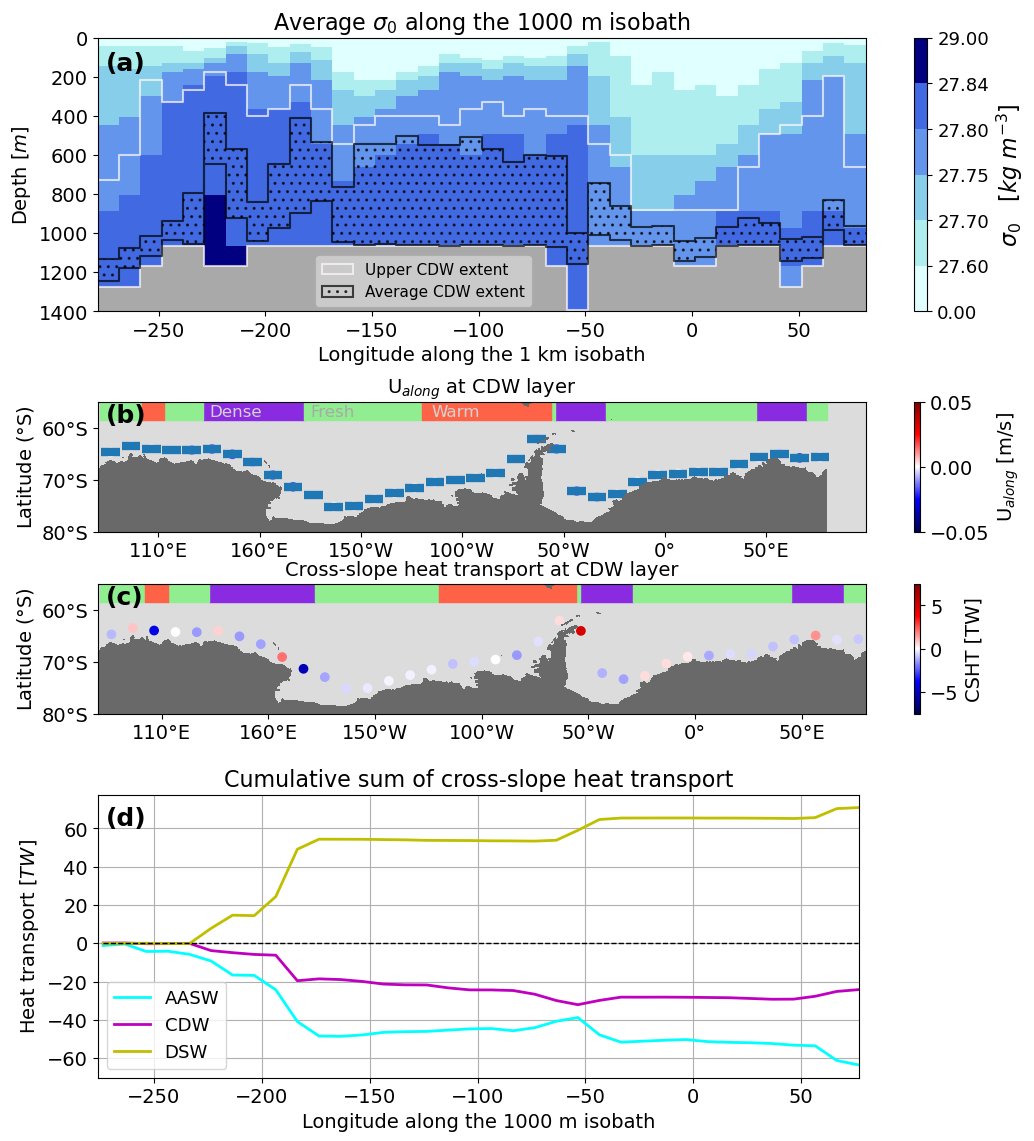

In [99]:
figure = plt.figure(num = 1, figsize = (12, 13))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0,
                    hspace=0.4)

ax=plt.subplot(3,1,1)
norm = col.Normalize(vmin=27.6,vmax=29)
levels = [0,27.6,27.7,27.75,27.8,27.84,29]

pc = σ_10deg_binned.mean('time').plot.pcolormesh(y='st_ocean',levels=levels,\
                                       colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue',\
                                               'navy'],add_colorbar=False)

plt.fill_between(lon_bin_halo,CDW_light_zmin_halo,CDW_dense_zmax_halo,color='snow',\
                 step='mid',hatch='',facecolor='none', alpha=.7, label='Upper CDW extent',linewidth=1.5)

plt.fill_between(lon_bin_halo,CDW_light_zmean_halo,CDW_dense_zmean_halo,\
                 step='mid',hatch='..',facecolor='none', alpha=0.7, label='Average CDW extent',linewidth=1.5)
ax.set_facecolor('darkgray')


plt.ylim(1400,0);
plt.tick_params(labelsize=14)
plt.ylabel(r'Depth [$m$]',fontsize=14)
plt.xlabel('Longitude along the 1 km isobath',fontsize=14)
plt.legend(fontsize=11, bbox_to_anchor=(0.574,0.23), facecolor='lightgray')

plt.title(r'Average $\sigma_0$ along the 1000 m isobath',fontsize=16)
cbr = plt.colorbar(pc)
cbr.ax.set_ylabel(ylabel=r"$\sigma_0$   [$kg\ m^{-3}$]",size=16)
cbr.ax.tick_params(labelsize=13)

ax.text(0.01,0.88,'(a)',transform=ax.transAxes, fontsize = 18, fontweight = 'bold')


spec = gridspec.GridSpec(ncols=2, nrows=2,
                         width_ratios=[12,0.1], wspace=0.5,
                         hspace=0.1, height_ratios=[1, 0.4])

ax2 = figure.add_subplot(spec[2])


(AASW_HT_10deg.mean('time').sum('potrho0')*1e-12).cumsum().plot(ax=ax2,color='cyan',\
                                                                linewidth=2,label='AASW')
(CDW_HT_10deg.mean('time').sum('potrho0')*1e-12).cumsum().plot(ax=ax2,color='m',\
                                                                linewidth=2,label='CDW')
(DSW_HT_10deg.mean('time').sum('potrho0')*1e-12).cumsum().plot(ax=ax2,color='y',\
                                                                linewidth=2,label='DSW')
(AASW_HT_10deg.mean('time').sum('potrho0')*0).plot(ax=ax2, linestyle='--', color='k',linewidth=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-276,77)
plt.title('Cumulative sum of cross-slope heat transport',fontsize=16)
plt.ylabel(r'Heat transport [$TW$]',fontsize=14)
plt.xlabel('Longitude along the 1000 m isobath',fontsize=14)
plt.grid()
legend1 = plt.legend(fontsize=13,loc='lower left')
ax2.text(0.01,0.89,'(d)',transform=ax2.transAxes, fontsize = 18, fontweight = 'bold')

fontsize=14

ax1 = figure.add_subplot(6,1,3)

# scat = ax1.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,
#                        c = U_along_annual_binned_CDW_plot,
#                        cmap = 'seismic', vmin = -0.05, vmax = 0.05)
ax1.hlines(lat_bins_10deg,lon - 4.6,  # Start of line
                lon + 4.6,  # End of line
                linewidth=6)  # Optional: Set line width            
scat = ax1.scatter(U_along_tmean_binned_CDW.lon_bins,lat_bins_10deg, c=U_along_tmean_binned_CDW.U, vmin=-0.05,vmax=0.05, cmap='seismic')

ax1.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='dimgrey', zorder=2)
ax1.set_facecolor('gainsboro') 
ax1.set_ylim([-80,-55])
ax1.set_ylabel('Latitude ($\degree$S)',fontsize=fontsize)
ax1.set_title('U$_{along}$ at CDW layer',fontsize=fontsize)
ax1.tick_params(labelsize=fontsize)

ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax1.xaxis.set_major_formatter(LongitudeFormatter())
ax1.text(0.01,0.84,'(b)',transform=ax1.transAxes, fontsize = 18, fontweight = 'bold')
# ax1.pcolormesh(lon_along_contour_ASC[:-1],[-59,-57], ASC_regimes_2d[:,:-1], cmap=CustomCmap_no3, alpha = 1)
## replace by Moorman et al. 2020
## THOMPSON et al 2018 COMPARISON (estimated from Figure 4)
## D regions
ax1.fill_between([-29,-54],[-58.5,-58.5],[-55, -55], color = 'blueviolet')
ax1.fill_between([-178,-228],[-58.5,-58.5],[1,1], color = 'blueviolet')
ax1.fill_between([70,45],[-58.5,-58.5],[1,1], color = 'blueviolet')
# ## F regions
ax1.fill_between([-54,-56],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax1.fill_between([-120,-178],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax1.fill_between([-228,-247],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax1.fill_between([-279,-258],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax1.fill_between([70,80],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax1.fill_between([-29,45],[-58.5,-58.5],[1,1], color = 'lightgreen')
# ## W regions
ax1.fill_between([-120,-56],[-58.5,-58.5],[1,1], color = 'tomato')
ax1.fill_between([-247,-258],[-58.5,-58.5],[1,1], color = 'tomato')
ax1.text(-115,-57.75,'Warm',color='lightgray',fontsize=12)#,weight='bold')
ax1.text(-175,-57.75,'Fresh',color='darkgray',fontsize=12)#,weight='bold')
ax1.text(-225,-57.75,'Dense',color='lightgray',fontsize=12)#,weight='bold')

cbar = plt.colorbar(scat)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('U$_{along}$ [m/s]', fontsize=14)


ax2 = figure.add_subplot(6,1,4)

# scat = ax2.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,
#                        c = CSHTZC_annual_binned_plot*1e-12,
#                        cmap = 'seismic', vmin = -7.5, vmax = 7.5)
scat = ax2.scatter(U_along_tmean_binned_CDW.lon_bins,lat_bins_10deg, c=CSHTZC_along_tmean_zsum_10deg_ds.variable_name*1e-12, vmin=-7.5,vmax=7.5, cmap='seismic')
ax2.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='dimgrey', zorder=2)
ax2.set_facecolor('gainsboro') 
ax2.set_ylim([-80,-55])
ax2.set_ylabel('Latitude ($\degree$S)',fontsize=fontsize)
# ax2.set_xlabel('Longitude ($\degree$E)',fontsize=fontsize)
ax2.set_title('Cross-slope heat transport at CDW layer',fontsize=fontsize)
ax2.tick_params(labelsize=fontsize)

ax2.yaxis.set_major_formatter(LatitudeFormatter())
ax2.xaxis.set_major_formatter(LongitudeFormatter())
ax2.text(0.01,0.84,'(c)',transform=ax2.transAxes, fontsize = 18, fontweight = 'bold')
ax2.fill_between([-29,-54],[-58.5,-58.5],[-55, -55], color = 'blueviolet')
ax2.fill_between([-178,-228],[-58.5,-58.5],[1,1], color = 'blueviolet')
ax2.fill_between([70,45],[-58.5,-58.5],[1,1], color = 'blueviolet')
# ## F regions
ax2.fill_between([-54,-56],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax2.fill_between([-120,-178],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax2.fill_between([-228,-247],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax2.fill_between([-279,-258],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax2.fill_between([70,80],[-58.5,-58.5],[1,1], color = 'lightgreen')
ax2.fill_between([-29,45],[-58.5,-58.5],[1,1], color = 'lightgreen')
# ## W regions
ax2.fill_between([-120,-56],[-58.5,-58.5],[1,1], color = 'tomato')
ax2.fill_between([-247,-258],[-58.5,-58.5],[1,1], color = 'tomato')

cbar = plt.colorbar(scat)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('CSHT [TW]', fontsize=14)

plt.savefig(figdir +'Fig1_final_v3.png',dpi=300)